# Zillow Regression Project

## Presented By: Kristine Cabanela

### December 13, 2021


# Project Summary

Zillow is a popular estimator for house evaluation available online. Zillow's estimations allow the homebuyers to search for a home that satisfies their location, area, budget, etc.

In this project we want to predict the property tax assessed values ('taxvaluedollarcnt') for single family properties. The focus will be the single unit properties that had a transaction during 2017.

We will be looking at key drivers of the tax assessed values for single family properties to help build accuracy.



In [1]:
# imports

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
from env import host, user, password
from scipy import stats

from sklearn.model_selection import train_test_split


# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Acquire and Prep - Wrangle

### Get data by creating a function that connects to the SQL server
- Acquire data by using a SQL query to Zillow table in the mySQL database.

### Perform a data cleanup:
- To ensure that the data we are evaluating is at a high quality meaning it is free of incorrect, irrelevant, or incomplete information which will minimize the risk of wrong or inaccurate conclusions.



In [2]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
# function to query database and return zillow df

def get_data_from_sql():
    query = """
    SELECT bedroomcnt as bedrooms, bathroomcnt as bathrooms, calculatedfinishedsquarefeet as square_feet, 
    taxvaluedollarcnt FROM properties_2017
    JOIN predictions_2017 as p USING(parcelid)
    WHERE transactiondate < '2018-01-01' AND propertylandusetypeid LIKE '261'
    """
    df = pd.read_sql(query, get_connection('zillow'))
    return df

In [4]:
# 

df = get_data_from_sql()

In [5]:
# get an overview of the data aquired

df.head()

,bedrooms,bathrooms,square_feet,taxvaluedollarcnt
0,4.0,3.5,3100.0,1023282.0
1,2.0,1.0,1465.0,464000.0
2,3.0,2.0,1243.0,564778.0
3,4.0,3.0,2376.0,145143.0
4,4.0,3.0,2962.0,773303.0


In [6]:
# How many rows and columns are present

df.shape

(52441, 4)

In [7]:
# An overview of the values in columns and rows

df.value_counts()

bedrooms  bathrooms  square_feet  taxvaluedollarcnt
3.0       2.5        1689.0       632000.0             3
2.0       1.5        1080.0       137444.0             3
3.0       2.0        1541.0       255000.0             3
2.0       1.5        1350.0       467000.0             3
          1.0        832.0        455000.0             3
                                                      ..
3.0       2.0        1328.0       521062.0             1
                     1329.0       87354.0              1
                                  124876.0             1
                                  160579.0             1
14.0      18.0       18654.0      49061236.0           1
Length: 52145, dtype: int64

# Preparing the Data

## Let's drop some existing rows that are not necessary
- First, we will remove null values.
- We can also take out duplicate values.
- More rows were observed with a value count of zero for bedrooms and bathrooms.
- After observation, we've found some outliers and we will drop those too.

In [8]:
# Find the total number of Null values in each column of our DataFrame.

df.isnull().sum()

bedrooms              0
bathrooms             0
square_feet          82
taxvaluedollarcnt     1
dtype: int64

In [9]:
# here we are going to drop null values in any columns

df = df.dropna()

In [10]:
# same as above to confirm

df.isnull().sum()

bedrooms             0
bathrooms            0
square_feet          0
taxvaluedollarcnt    0
dtype: int64

In [11]:
# confirmation that above code worked to drop nulls

df.isnull().any()

bedrooms             False
bathrooms            False
square_feet          False
taxvaluedollarcnt    False
dtype: bool

In [12]:
# more confirmation that the above code has dropped the rows with existing null values

df.shape

(52358, 4)

In [13]:
# drop duplicates

df = df.drop_duplicates()

In [14]:
# confirm cell above that duplicates have been dropped

df.shape

(52145, 4)

## Finding more unneeded values


In [15]:
# Drop all rows with 0 value.

df = df[df.bathrooms != 0]
df = df[df.bedrooms != 0]

In [16]:
# confirmed that rows with 0 value have been dropped

df.shape

(52068, 4)

### Here, is an example of some observed data that differs substantially from the rest of our data.  
- We will create a function to remove these.

In [17]:
# Here we can take a look at bedrooms column and see what they values are and how many of each value are present

df['bedrooms'].value_counts(ascending=True)

14.0        1
11.0        1
12.0        1
10.0        2
9.0         8
8.0        24
7.0       106
1.0       603
6.0       633
5.0      3965
2.0      8296
4.0     15185
3.0     23243
Name: bedrooms, dtype: int64

In [18]:
# We can use the same code above to see the same information but for the bathrooms column instead

df['bathrooms'].value_counts(ascending=True)

13.0        1
18.0        1
8.5         3
11.0        3
10.0        5
9.0        13
7.5        16
6.5        47
8.0        53
7.0        88
5.5       223
6.0       320
4.5       685
5.0       802
1.5       824
3.5       914
4.0      2223
2.5      3915
1.0      9498
3.0     10634
2.0     21800
Name: bathrooms, dtype: int64

### Let's Drop some more data
### Outliers
### This function's purpose is to remove outliers

In [19]:
#function to remove outliers in x columns

def remove_outliers(df, k, col_list):
    ''' 
    Takes in a df, k, and list of columns returns
    a df with removed outliers
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

### The function created will be implemented to the all of the columns listed 
see below cell

In [20]:
# use above function to remove outliers for columns listed and apply to new df

df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'square_feet', 'taxvaluedollarcnt'])
df

,bedrooms,bathrooms,square_feet,taxvaluedollarcnt
0,4.0,3.5,3100.0,1023282.0
1,2.0,1.0,1465.0,464000.0
2,3.0,2.0,1243.0,564778.0
3,4.0,3.0,2376.0,145143.0
4,4.0,3.0,2962.0,773303.0
...,...,...,...,...
52436,4.0,2.0,1633.0,346534.0
52437,2.0,2.0,1286.0,354621.0
52438,4.0,2.0,1612.0,67205.0
52439,3.0,1.0,1032.0,49546.0


In [21]:
## Confirmed.
### outliers not present

In [22]:
# Same code used previously to check the values specific to the bedrooms column 
# Now the outliers have been removed

df['bedrooms'].value_counts(ascending=False)

3.0    22015
4.0    13048
2.0     8031
5.0     2339
Name: bedrooms, dtype: int64

In [23]:
# More confirmation outliers also removed for bathrooms column

df['bathrooms'].value_counts(ascending=True)

3.5      477
1.5      816
4.0     1052
2.5     3765
1.0     8865
3.0     9374
2.0    21084
Name: bathrooms, dtype: int64

# Lets write a function for this
After preparing my dataset I've created a function to apply all the changes

In [24]:
def wrangle_zillow():
    '''
    Read student_grades csv file into a pandas DataFrame,
    drop student_id column, replace whitespaces with NaN values,
    drop any rows with Null values, convert all columns to int64,
    return cleaned student grades DataFrame.
    '''
    # Acquire data from csv file.
    df = get_data_from_sql()
    
    # Replace white space values with NaN values.
    df = df.replace(r'^\s*$', np.nan, regex=True)
    
    # Drop any Duplicates
    df = df.drop_duplicates()

    # Drop all rows with 0 values.
    df = df[df.bathrooms != 0]
    df = df[df.bedrooms != 0]
    
    # here we are going to drop null values in any columns
    df.isnull().sum()
    
    # Remove Outliers
    df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'square_feet', 'taxvaluedollarcnt'])
    
    # Convert datatypes to int
    df = df.astype('int')
    

    # clean data with split
    train, test = train_test_split(df, test_size = .2, random_state = 123)
    train, validate = train_test_split(train, test_size = .3, random_state = 123)
    
    return df 

In [25]:
# Named my dataframe with function implemented

wrangle_zillow = wrangle_zillow()

# Let's split our data

In [26]:
# 20% test, 80% train_validate
# then of the 80% train_validate: 30% validate, 70% train.

train, test = train_test_split(wrangle_zillow, test_size = .2, random_state = 123)
train, validate = train_test_split(train, test_size = .3, random_state = 123)



In [27]:
# Validate my split.

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (25442, 4)
validate -> (10904, 4)
test -> (9087, 4)


In [28]:
# Function created to split dataset

def split_data(df):
    '''
    take in a DataFrame and return train, validate, and test DataFrames
    return train, validate, test DataFrames.
    '''
    train, test = train_test_split(wrangle_zillow, test_size = .2, random_state = 123)
    train, validate = train_test_split(train, test_size = .3, random_state = 123)
    
    return train, validate, test

In [29]:
# apply split_data function to dataset

train, validate, test = split_data(wrangle_zillow)

In [30]:
# Validate my split.

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (25442, 4)
validate -> (10904, 4)
test -> (9087, 4)


In [31]:
# Rows and columns for train, validate, and test

train.shape, validate.shape, test.shape

((25442, 4), (10904, 4), (9087, 4))

# Explore

### Initial Questions
- What is the relationship between bedroom count and tax value dollar count?
    - Is it a linear relationship or is there no relationship?
    
    
- What is the relationship between bathroom count and tax value dollar count?
    - Is it a linear relationship or is there no relationship?
    

- What is the relationship between square feet and tax value dollar count?
    - Is it a linear relationship or is there no relationship?


### Question 1
Is there a relationship between bedroom count and taxvaluedollarcount?

Object `relationship` not found.


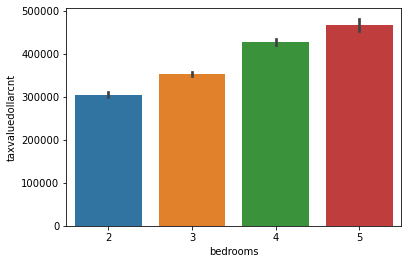

In [32]:
# Here we've created a bar graph so we can visualize how the number of bedrooms correlates to the tax value

sns.barplot(x = 'bedrooms',y='taxvaluedollarcnt',data=train)
- Is it a linear relationship or is there no relationship?

In [33]:
# Let's run a chi squared to compare proportions, to have more confidence

alpha = 0.05

null_hypothesis = "taxvaluedollarcnt and bedrooms are independent"
alternative_hypothesis = "there is a relationship between taxvaluedollarcnt and bedrooms"

# Setup a crosstab of taxval to bedrooms
observed = pd.crosstab(train.bedrooms, train.taxvaluedollarcnt)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that taxvaluedollarcnt and bedrooms are independent", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")

Reject the null hypothesis that taxvaluedollarcnt and bedrooms are independent taxvaluedollarcnt and bedrooms are independent
Sufficient evidence to move forward understanding that there is a relationship between taxvaluedollarcnt and bedrooms


### Question 2
What is the relationship between bathroom count and taxvaluedollarcount?
- Is it a linear relationship or is there no relationship?

<AxesSubplot:xlabel='bathrooms', ylabel='taxvaluedollarcnt'>

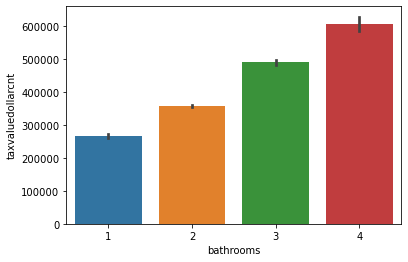

In [34]:
# Here we've created a bar graph so we can visualize how the number of bathrooms correlates to the tax value

sns.barplot(x = 'bathrooms',y='taxvaluedollarcnt',data=train)

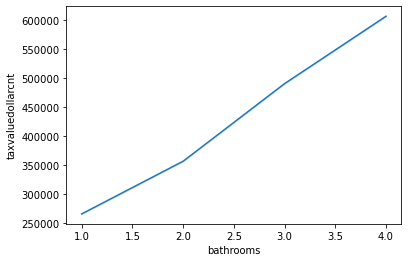

In [35]:
# Lets see if there is a linear regression with a line plot

sns.lineplot(x="bathrooms", y="taxvaluedollarcnt", ci=False,  data=train);

### Question 3
What is the relationship between square feet and taxvaluedollarcount?
- Is it a linear relationship or is there no relationship?

<AxesSubplot:xlabel='square_feet', ylabel='taxvaluedollarcnt'>

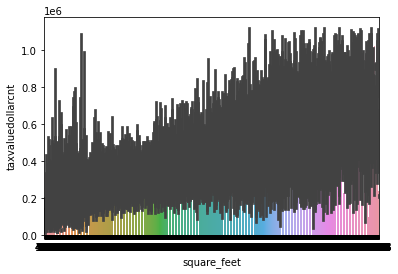

In [36]:
# Here we've created a bar graph so we can visualize how high or low the square footage is related to the tax value 

sns.barplot(x = 'square_feet',y='taxvaluedollarcnt',data=train)

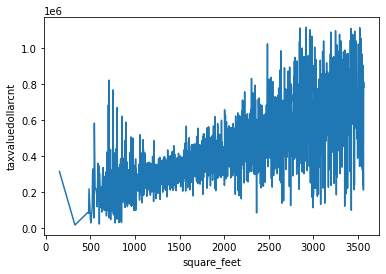

In [37]:
# Lets see if there is a linear regression with a line plot

sns.lineplot(x="square_feet", y="taxvaluedollarcnt", ci=False,  data=train);

In [38]:
# For further evidence of the relationship between square footage and tax value we've run a stats test.

alpha = 0.05

null_hypothesis = "taxvaluedollarcnt and square feet are independent"
alternative_hypothesis = "there is a relationship between taxvaluedollarcnt and square feet"

# Setup a crosstab of taxvalue to bedrooms
observed = pd.crosstab(train.square_feet, train.taxvaluedollarcnt)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that taxvaluedollarcnt and square feet are independent", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")

Reject the null hypothesis that taxvaluedollarcnt and square feet are independent taxvaluedollarcnt and square feet are independent
Sufficient evidence to move forward understanding that there is a relationship between taxvaluedollarcnt and square feet


# Model

In [39]:
X_train = train.drop(columns=['taxvaluedollarcnt'])
y_train = train.taxvaluedollarcnt

X_validate = validate.drop(columns=['taxvaluedollarcnt'])
y_validate = validate.taxvaluedollarcnt

X_test = test.drop(columns=['taxvaluedollarcnt',])
y_test = test.taxvaluedollarcnt

In [40]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25442, 3), (25442,), (9087, 3), (9087,))

### Baseline

In [41]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values.

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict pred_mean
pred_mean = y_train['taxvaluedollarcnt'].mean()
y_train['pred_mean'] = pred_mean
y_validate['pred_mean'] = pred_mean

# 2. compute pred_median
pred_median = y_train['taxvaluedollarcnt'].median()
y_train['pred_median'] = pred_median
y_validate['pred_median'] = pred_median

# 3. RMSE of pred_mean
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of pred_median
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  244209.66 
Validate/Out-of-Sample:  245727.09
RMSE using Median
Train/In-Sample:  246803.94 
Validate/Out-of-Sample:  248966.8


In [42]:
# We will choose mean as the baseline with this data set
train['baseline'] = train.taxvaluedollarcnt.mean()

baseline = train["taxvaluedollarcnt"].mean()
train['baseline'] = baseline
train.head()

,bedrooms,bathrooms,square_feet,taxvaluedollarcnt,baseline
50535,3,1,1118,405564,371892.685874
31469,2,2,2997,827695,371892.685874
13340,4,2,2118,589831,371892.685874
36492,2,1,1049,296461,371892.685874
1411,5,3,2131,272697,371892.685874


### OLS

In [43]:
# Create model
lm = LinearRegression(normalize=True,)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvalue_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_lm)**(1/2)

# predict validate
y_validate['taxvalue_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  217575.41353073844 
Validation/Out-of-Sample:  218330.7046624408


### LassoLars

In [44]:
# create the model object
lars = LassoLars(alpha=50)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvalue_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_lars)**(1/2)

# predict validate
y_validate['taxvalue_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  218392.73611393286 
Validation/Out-of-Sample:  219091.3124558128


### TweedieRegressor (GLM)

In [45]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvaluedollarcnt_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_glm)**(1/2)

# predict validate
y_validate['taxvaluedollarcnt_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  244209.663997758 
Validation/Out-of-Sample:  245727.09011076426


### Evaluate on Test

In [46]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['taxvalue_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.taxvaluedollarcnt, y_test.taxvalue_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  217473.11736898244


## Conclusion Summary
- There is somewhat of a relationship between bathrooms, square feet, and bedroom count in predicting the tax value dollar count of single family units.  Bathrooms were shown as the biggest driver while the size of the unit followed. The number of bedrooms was the least greatest factor among the three when it comes to the home value.

## Conclusion Recommendations
- Feature Engineering
    - We can add this step to extract more information from our already existing data.  With new features implemented we can extract new information and more insights that may be able to improve our model accuracy.

## Conclusion Next Steps

- Drivers include: number of bathrooms, square feet, and bedroom count
- With more time I would work on improving the model adding more parameters